In [7]:
####### 순전파와 역전파 후크 등록
import torch


class GradCAM:
    def __init__(self, model, main, sub):
        self.model = model.eval()
        # 마지막 함성곱 계층을 받아옴
        # ResNet-18의 마지막 계층: layer4(main)의 conv2(sub)
        self.register_hook(main, sub)

    # 후크 등록 메서드 : 모델의 하위 모듈을 검색
    def register_hook(self, main, sub):
        for name, module in self.model.named_children():
            if name == main:
                for sub_name, sub_module in module[-1].named_children():
                    if sub_name == sub:
                        # 마지막 계층에서 순방향 후크와 역방향 후크를 등록
                        # 순/역방향 후크: 해당 모듈의 순/역(backward)방향 연산이 진행될 때 호출됨
                        sub_module.register_forward_hook(self.forward_hook)
                        sub_module.register_full_backward_hook(self.backward_hook)
    
    def forward_hook(self, module, input, output):
        # 순방향 연산의 출력값(마지막 계층이므로 특징맵)을 feature_map에 저장
        self.feature_map = output            # [N, 512, 7, 7]
    
    def backward_hook(self, module, grad_input, grad_output):
        # 기울기 출력값은 튜플로 감싸인텐서를 가지고 있으므로 첫번째 텐서만 반환
        self.gradient = grad_output[0]      # [N, 512, 7, 7]

####### Grad-CAM 생성        
    def __call__(self, x):
        output = self.model(x)              # [N,1000]

        # 이미지마다 예측 클래스 반환
        index   = output.argmax(axis=1)     # [N,1]
        one_hot = torch.zeros_like(output)  # [N, 1000]
        for i in range(output.size(0)):     
            one_hot[i][index[i]] = 1        # [N,1000]-예측클래스 1, 나머지 0(one-hot)

        self.model.zero_grad()
        # 특정 클래스의 예측에 기여한 특징만 파악 위해 원-핫 벡터 사용
        output.backward(gradient=one_hot, retain_graph=True)
        
        ### k번 채널의 미분평균값
        #self.gradient: 특정 클래스에 대한 역전파를 통해 계산된 그래디언트 맵, [N, 512, 7, 7]
        #dim=(2, 3): 여기서 dim=(2, 3)는 텐서의 세 번째와 네 번째 차원을 기준으로 평균을 계산. 즉, 각 채널별로 그래디언트의 평균을 계산
        a_k = torch.mean(self.gradient, dim=(2, 3), keepdim=True) # [4,512,1,1]
        ### 미분값을 반영한 특징맵
        # dim=1: dim=1은 텐서의 두 번째 차원(채널 차원)을 기준으로 합산하라는 의미
        # 결과 텐서는 일반적으로 [N, C, H, W] 형태를 가지고 있음        
        grad_cam = torch.sum(a_k * self.feature_map, dim=1) # [N, 7, 7]
        # 음수값을 제외하고 활성화된 영역만을 강조 [N, 7, 7]
        grad_cam = torch.relu(grad_cam)
        return grad_cam

torch.Size([4, 512, 7, 7])


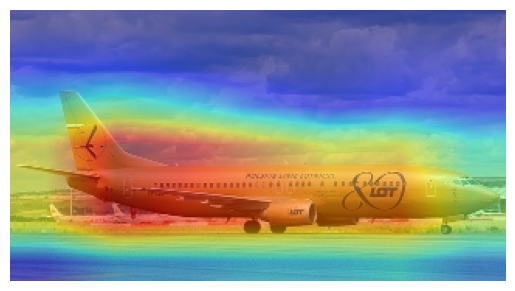

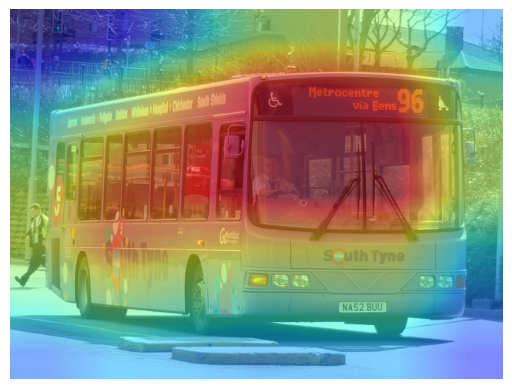

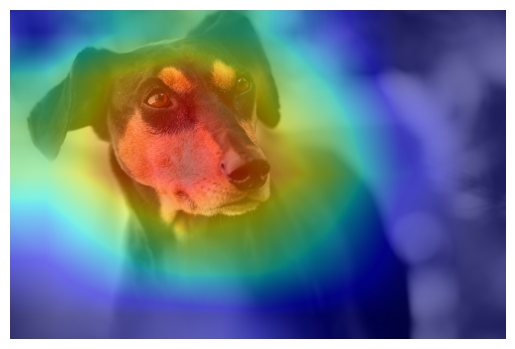

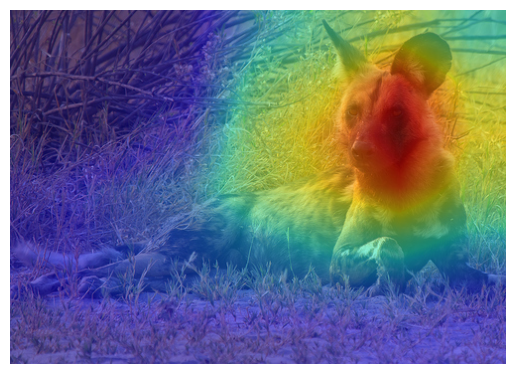

In [8]:
####### Grad-CAM 시각화
from PIL import Image
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

files = [
    "../datasets/images/airplane.jpg", "../datasets/images/bus.jpg",
    "../datasets/images/dog.jpg", "../datasets/images/african_hunting_dog.jpg"
]
images, tensors = [], []
for file in files:
    image = Image.open(file)
    images.append(image)
    tensors.append(transform(image))
tensors = torch.stack(tensors)

model = GradCAM(
    model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1"),
    main  = "layer4",
    sub   = "conv2"
)
# 특징맵 추출
grad_cams = model(tensors)

for idx, image in enumerate(images):
    # 특징맵 크기 변경
    grad_cam = F.interpolate(
        input = grad_cams[idx].unsqueeze(0).unsqueeze(0),
        # size(출력텐서의 공간크기) : (높이, 너비)로 지정
        size  = (image.size[1], image.size[0]),
        mode  = "bilinear",
    ).squeeze().detach().numpy()

    plt.imshow(image)
    # jet: 영향 많이 주는 부분-붉은색 <-> 영향 적은 부분-파란색
    plt.imshow(grad_cam, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.show()